In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [2]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='Unnamed: 0')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2013-01-31 to 2024-08-31
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              136 non-null    float64
 1   crude_oil_brent_usd_per_bbl              140 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         140 non-null    float64
 3   inflación_mensual                        140 non-null    float64
 4   ipc_diesel                               140 non-null    float64
 5   precipitación_media_mm                   132 non-null    float64
 6   temp_media_Celsius                       132 non-null    float64
 7   fob_otros_prod_agrícolas_exportados_usd  140 non-null    float64
 8   fosfato diamónico 18-46-0                140 non-null    float64
 9   muriato de potasio 0-0-60                140 non-null    float64
 10  urea 46-0-0                    

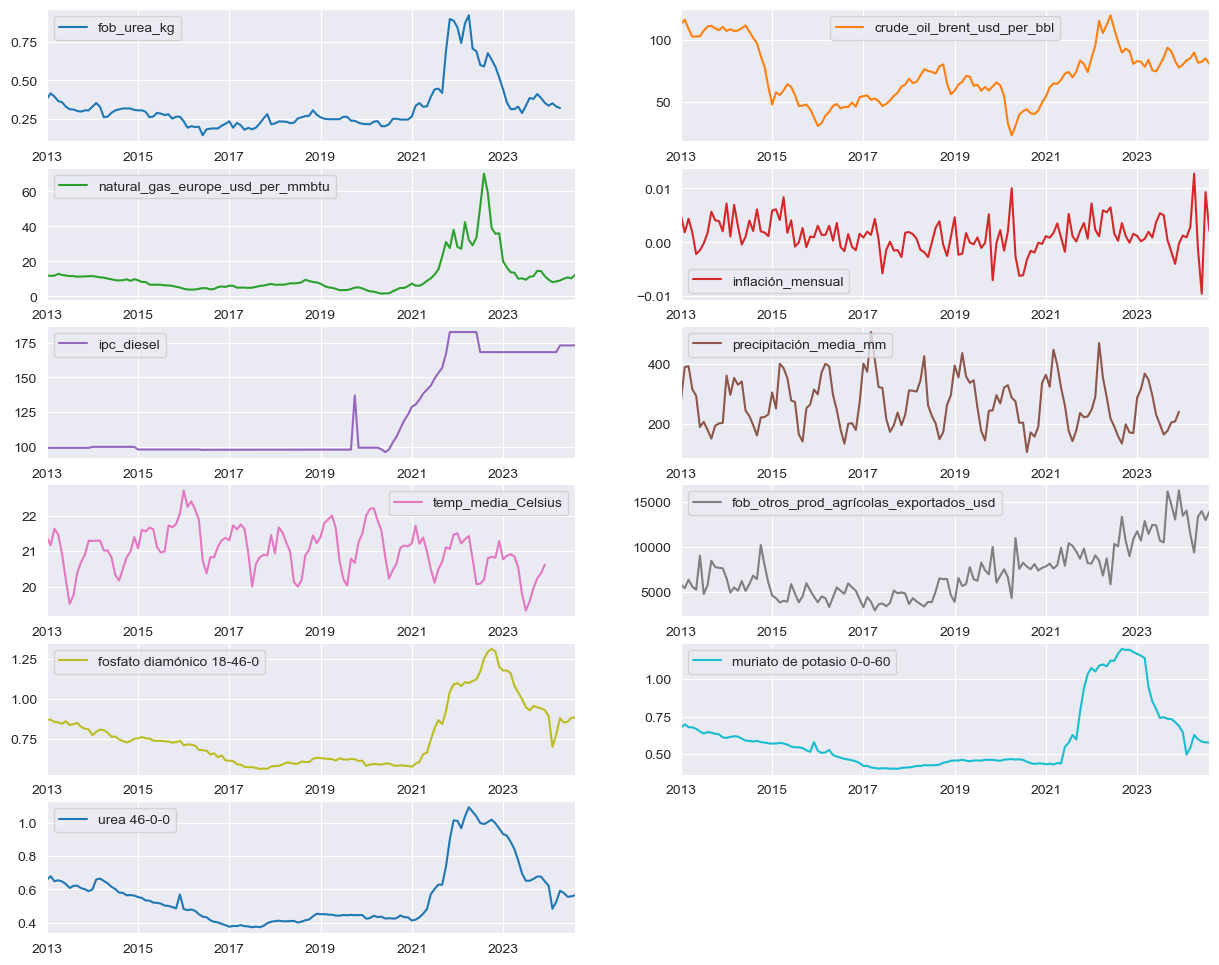

In [3]:
num_de_filas = ((df.shape[1] + 1) // 2)

df.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

In [4]:
# Extraer variables predictoras:
X = df.drop(columns=['fosfato diamónico 18-46-0', 'muriato de potasio 0-0-60', 'urea 46-0-0'])

# Extraer variable objetivo:
target_var = 'urea 46-0-0'

In [5]:
# Uso de la función
# plot_ccf_subplots(df, X.columns.tolist(), target_var, max_lag=30, palette_name="tab20")


### Diferenciación no-estacional y estacional

Estacionareidad por *Dickey-Fuller* y *Kwiatkowski-Phillips-Schmidt-Shin*:

In [7]:
# Eliminar valores nulos para análisis de estacionareidad:
df_sin_na = df.dropna()

# Evaluar estadísticos ADF y KPSS de estacionareidad:
df_test_estacionareidad = evaluar_estacionareidad(df_sin_na)

df_test_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg,2.361962e-01,0.022258,False,True,No estacionario
1,crude_oil_brent_usd_per_bbl,1.067201e-01,0.100000,False,False,No claro
2,natural_gas_europe_usd_per_mmbtu,2.756353e-01,0.031976,False,True,No estacionario
3,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
4,ipc_diesel,9.639810e-01,0.010000,False,True,No estacionario
5,precipitación_media_mm,1.298639e-01,0.100000,False,False,No claro
6,temp_media_Celsius,5.043799e-01,0.100000,False,False,No claro
7,fob_otros_prod_agrícolas_exportados_usd,9.990506e-01,0.010000,False,True,No estacionario
8,fosfato diamónico 18-46-0,3.972852e-01,0.023077,False,True,No estacionario
9,muriato de potasio 0-0-60,4.079042e-01,0.019878,False,True,No estacionario


In [12]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

diffs_dict = {}

for col in df.columns:
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df_sin_na[col])

    # Determinar el número de diferenciaciones estacionales
    D = nsdiffs(df_sin_na[col], m=12)
    
    # Almacenar valores de diferenciación:
    diffs_dict[col] = {'D' : D, 'd' : d}

diffs_dict

{'fob_urea_kg': {'D': 0, 'd': 1},
 'crude_oil_brent_usd_per_bbl': {'D': 0, 'd': 0},
 'natural_gas_europe_usd_per_mmbtu': {'D': 0, 'd': 1},
 'inflación_mensual': {'D': 0, 'd': 0},
 'ipc_diesel': {'D': 0, 'd': 1},
 'precipitación_media_mm': {'D': 0, 'd': 0},
 'temp_media_Celsius': {'D': 0, 'd': 0},
 'fob_otros_prod_agrícolas_exportados_usd': {'D': 0, 'd': 1},
 'fosfato diamónico 18-46-0': {'D': 0, 'd': 1},
 'muriato de potasio 0-0-60': {'D': 0, 'd': 1},
 'urea 46-0-0': {'D': 0, 'd': 1}}

In [25]:
mes_2 = df_sin_na.index.min() + pd.DateOffset(months=1)
mes_2 = mes_2.strftime('%Y-%m')

último_mes = df_sin_na.index.max() + pd.DateOffset(months=1)
último_mes = último_mes.strftime('%Y-%m')

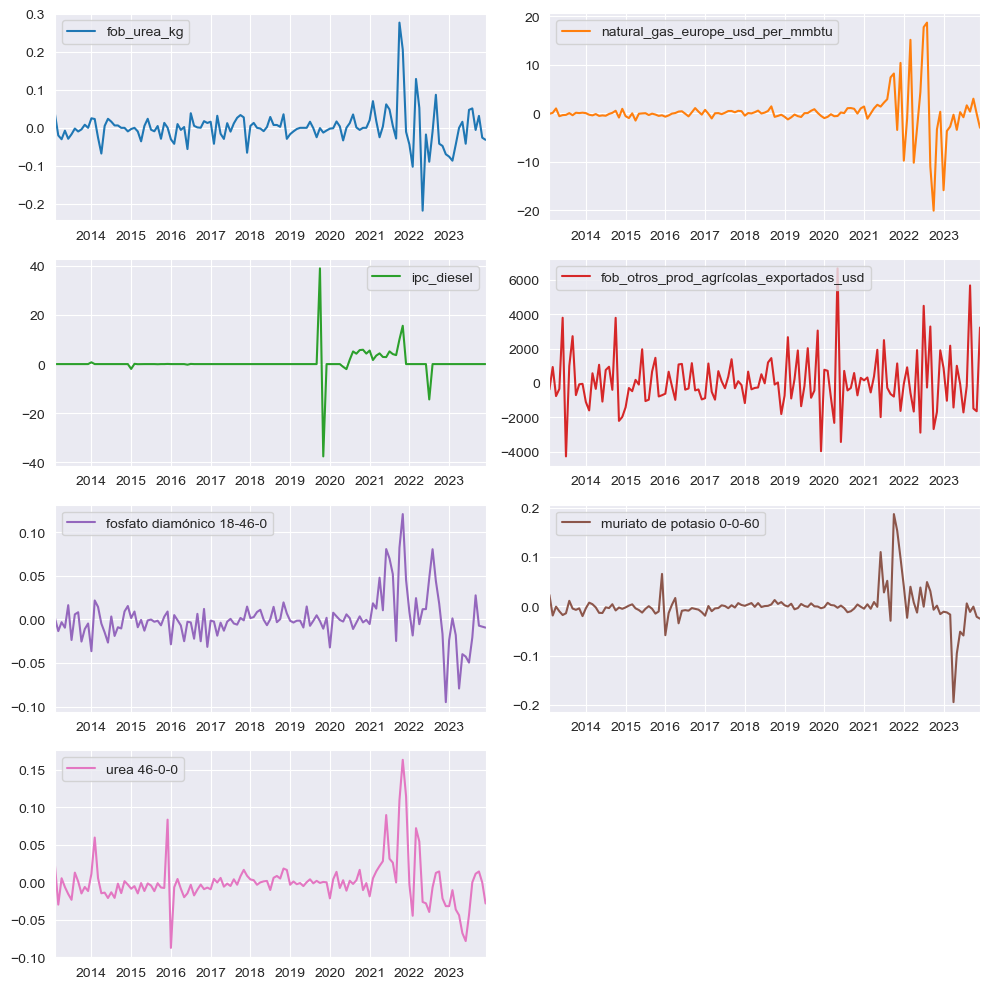

In [26]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

variables_no_estacionarias = df_test_estacionareidad.query("estado_estacionario == 'No estacionario'")['variable'].values

df_no_estacionarias = df_sin_na[variables_no_estacionarias]

df_diferenciadas = pd.DataFrame(index=pd.date_range(start=mes_2, end=último_mes, freq='ME'))

for col in variables_no_estacionarias:
    
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df_no_estacionarias[col])
    
    df_diferenciadas[col] = np.diff(df_no_estacionarias[col], n=d)

df_diferenciadas.plot(
    subplots=True,
    layout=(int(np.ceil(len(df_diferenciadas)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

In [27]:
# df_outliers_recortados = df_diferenciadas.apply(cap_outliers_by_percentile, lower_percentile=0.15, upper_percentile=0.85)

# df_outliers_recortados.plot(
#     subplots=True,
#     layout=(int(np.ceil(len(variables_no_estacionarias)/2)), 2),
#     figsize=(10, 10),
#     sharex=False,
#     sharey=False
#     )
# plt.tight_layout()
# plt.show()

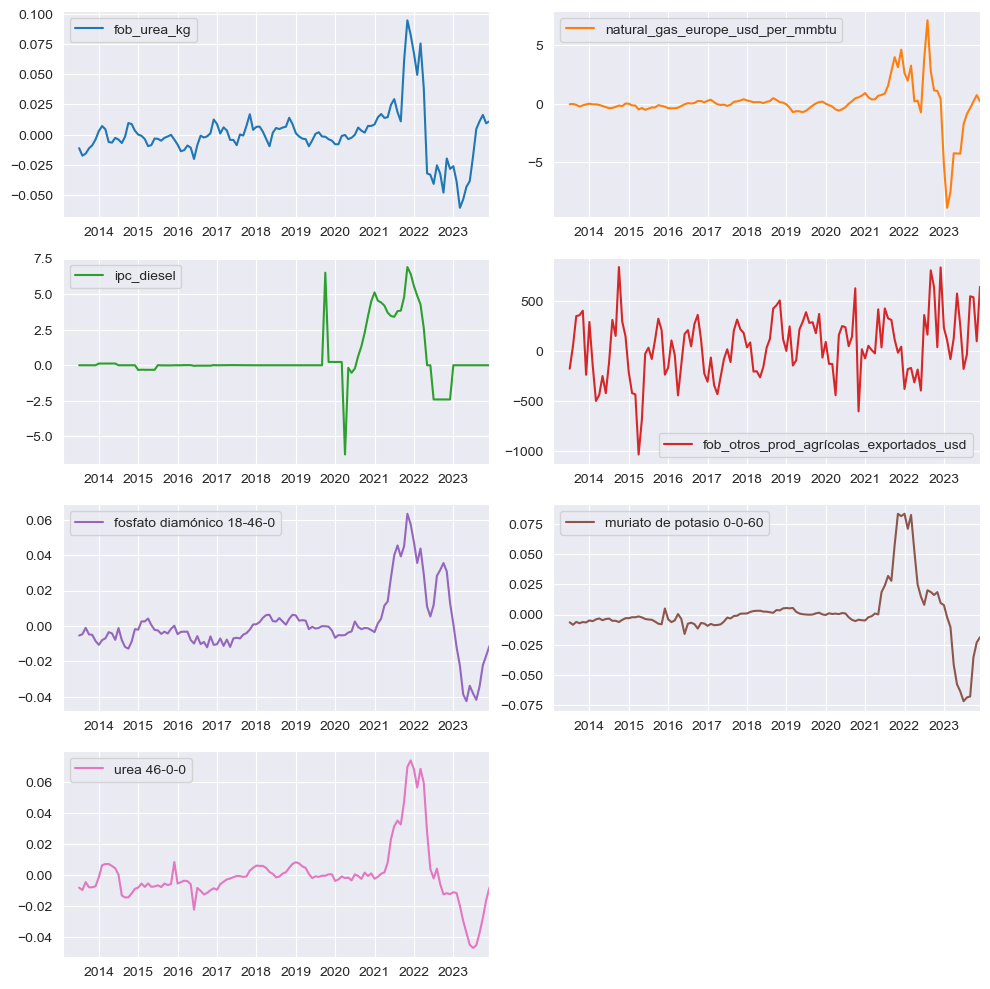

In [33]:
df_diferenciadas_rolling = df_diferenciadas.rolling(6).mean()

df_diferenciadas_rolling.plot(
    subplots=True,
    layout=(int(np.ceil(len(variables_no_estacionarias)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()